In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dtype = np.dtype('float32')
path = "../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar1/L197621_SAP0_BEAM1_DM12.44_mask.dat"
with open( path, 'rb') as f:
    pulsar_data = np.fromfile(f, dtype)
pulsar_data

array([1354649.2, 1379855.1, 1374663.1, ..., 1479622.2, 1479622.2,
       1479622.2], dtype=float32)

In [3]:
dt = 0.00262143998406827
nbins = 69120 
total_time = nbins * dt
time = [t*dt for t in np.arange(0, nbins)]

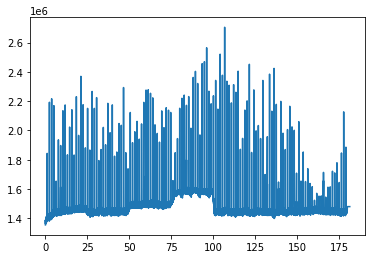

In [4]:
plt.plot(time, pulsar_data)

In [5]:
%matplotlib inline

(0.0, 209.80255598842447)

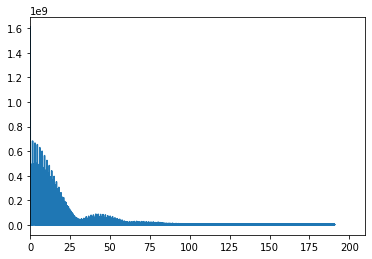

In [6]:
frequencies  = np.fft.fftfreq(69120, 0.00262143998406827)
transform = np.fft.fft(pulsar_data)
plt.plot(frequencies[1:], abs(transform[1:]))
plt.xlim(0)

following calculation does what we can do with fftfreq.

In [7]:
dtime = 0.00262143998406827
nbins = len(pulsar_data)
total_time = dtime * nbins
total_time

181.19393169879882

In [8]:
dnu = 1 / total_time
dnu

0.005518948623855206

In [9]:
from scipy.signal import find_peaks
peaks_index, properties = find_peaks(np.abs(transform), height=0.4* 10 **9)

In [10]:
peaks_index
peak_frequencies = [frequencies[i] for i in peaks_index]
print(peak_frequencies)
print(len(peak_frequencies))

[0.02759474311927603, 0.7450580642204528, 1.4956350770647608, 2.2406931412852136, 2.9912701541295217, 3.736328218349975, 4.4869052311942825, 5.231963295414736, 5.982540308259043, 6.7275983724794965, 7.478175385323804, 8.223233449544257, 8.973810462388565, 9.718868526609018, 10.469445539453327, 11.21450360367378, 11.965080616518087, 13.460715693582848, -13.460715693582848, -11.965080616518087, -11.21450360367378, -10.469445539453327, -9.718868526609018, -8.973810462388565, -8.223233449544257, -7.478175385323804, -6.7275983724794965, -5.982540308259043, -5.231963295414736, -4.4869052311942825, -3.736328218349975, -2.9912701541295217, -2.2406931412852136, -1.4956350770647608, -0.7450580642204528, -0.02759474311927603]
36


In [11]:
period = 0.7450580642204528 ** -1 *2 

## stacking

In [12]:

period_in_index = int(period // dtime)

stack_dict = dict()
i = 0
while i < int(nbins):
    stack_dict[f"stack{i // period_in_index}"] = np.array( pulsar_data[i:i+period_in_index])
    i += period_in_index
len(stack_dict)

68

In [13]:
stack = np.zeros(period_in_index)
for key, val in stack_dict.items():
    if ( length := len(val) ) != period_in_index: # this happens at the end.
        print(f'Length of the dictionary element {key} is not {period_in_index}, Did you expect this?')
        stack += np.append(val, np.zeros(period_in_index - length )) # fill with zeroes to keep the same size.
    else:
        stack += val
len(stack) == period_in_index

Length of the dictionary element stack67 is not 1024, Did you expect this?


True

In [14]:
time2 = [dt*t for t in range(len(stack))]

Text(0.5, 1.0, 'graph of an addition of signals of the first radio pulsar ever found.')

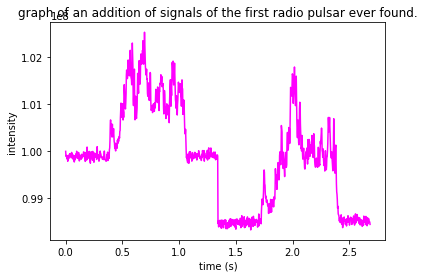

In [15]:
plt.plot(time2,stack, color='magenta')
plt.xlabel('time (s)')
plt.ylabel('intensity')
plt.title('graph of an addition of signals of the first radio pulsar ever found.')

